# Importing libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
import glob
import os
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools

import keras
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Softmax, BatchNormalization
from keras.optimizers import RMSprop, Nadam, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


# Reading training and test data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#Function to plot a nice confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    fig = plt.figure()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('predicted label')
    
    #return fig

# Data Pre-processing

In [4]:
#Separing the label from each training item
y_train = train['label']
X_train = train.drop(['label'],axis = 1)

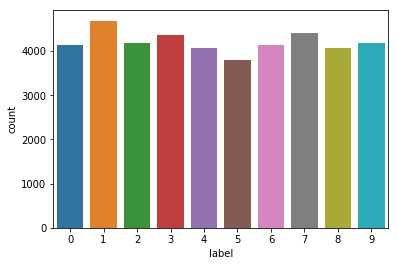

In [5]:
#Checking if the data is balanced
sns.countplot(y_train)

In [6]:
#Normalizing features
X_train = X_train / 255.0
test = test / 255.0

In [7]:
#Reshaping each item
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

n_rows = n_cols = 28

### Separating train and validation data

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

In [9]:
X_train.shape

(37800, 28, 28, 1)

In [10]:
X_val.shape

(4200, 28, 28, 1)

In [11]:
y_val.shape

(4200,)

In [12]:
y_train.shape

(37800,)

In [13]:
#To one-hot-encoding
y_train = to_categorical(y_train,num_classes=10)
y_val = to_categorical(y_val)

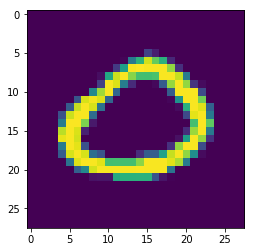

In [14]:
#Visualizing a train example
plt.imshow(X_train[1000][:,:,0])

In [15]:
#Making the CNN model
model = Sequential()

model.add(Conv2D(64, (5,5), padding='same', activation='relu', input_shape=(n_rows, n_cols, 1)))
model.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(378, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
__________

In [16]:
# Other things to the neural net
nadam = Nadam(lr = 0.001)
adam = Adam(lr = 0.001)
filepath = 'Pesos/CNN.{epoch:02d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.hdf5'
lr_red = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
chkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.compile(optimizer = adam , loss = "categorical_crossentropy", metrics=["accuracy"])

In [17]:
# Data Augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [18]:
#Loading best weights
model.load_weights('Pesos/MNIST-best.hdf5')

In [ ]:
history = model.fit(X_train, y_train, batch_size = 256, epochs = 75, initial_epoch = 0, 
                    validation_data = (X_val, y_val), callbacks=[lr_red, chkpoint])

In [ ]:
# Plot training & validation accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       408
           1     1.0000    1.0000    1.0000       471
           2     0.9976    1.0000    0.9988       420
           3     0.9980    1.0000    0.9990       506
           4     0.9975    1.0000    0.9987       397
           5     1.0000    1.0000    1.0000       339
           6     1.0000    0.9975    0.9988       402
           7     1.0000    0.9977    0.9989       438
           8     0.9975    0.9950    0.9963       403
           9     1.0000    1.0000    1.0000       416

   micro avg     0.9990    0.9990    0.9990      4200
   macro avg     0.9991    0.9990    0.9990      4200
weighted avg     0.9990    0.9990    0.9990      4200



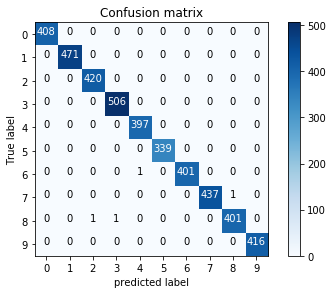

In [19]:
#Classification report and Confusion Matrix
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred,axis = 1) 
y_true = np.argmax(y_val,axis = 1) 
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
print(classification_report(y_true, y_pred_classes, digits=4))
plot_confusion_matrix(confusion_mtx, classes = range(10), normalize=False) 

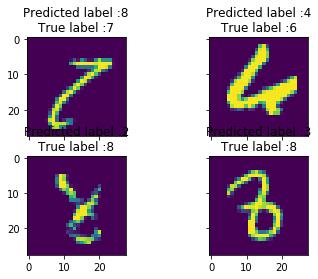

In [20]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 2
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
y_pred_errors_prob = np.max(y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 4 errors 
most_important_errors = sorted_dela_errors[-4:]

# Show the top 4 errors
display_errors(most_important_errors, X_val_errors, y_pred_classes_errors, y_true_errors)

In [21]:
#prediction on the test set
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [22]:
#Submission to Kaggle
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv('submission',index=False)